In [9]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import PIL
import os
import sys

In [10]:
class lane_dectection():
    def __init__(self,input):
        self.input = input
        self.input = cv2.resize(self.input, (960,640))
        self.vertices = np.array([[[0,550],[450,350],[600,350],[960,550]]])
        
    def grayscale(self):
        return cv2.cvtColor(self.input, cv2.COLOR_BGR2GRAY)
    
    def canny(self, low_threshold, high_threshold):
        return cv2.Canny(self.input, low_threshold, high_threshold)
    
    def gaussian_blur(self, kernel_size):
        self.input = cv2.GaussianBlur(self.input, (kernel_size, kernel_size), 0)
        self.input = cv2.GaussianBlur(self.input, (kernel_size, kernel_size), 0)
        return cv2.GaussianBlur(self.input, (kernel_size, kernel_size), 0)
    
    def region_of_interest(self, vertices):
        mask = np.zeros_like(self.input)
        cv2.fillPoly(mask, self.vertices, 255)
        masked_image = cv2.bitwise_and(self.input, mask)
        return masked_image
    
    def draw_lines(self, lines, color=[255, 0, 0], thickness=3):
        for line in lines:
            for x1,y1,x2,y2 in line:
                cv2.line(self.input, (x1, y1), (x2, y2), color, thickness)
                
    def hough_lines(self, rho, theta, threshold, min_line_len, max_line_gap):
        lines = cv2.HoughLinesP(self.input, rho, theta, threshold, np.array([]), minLineLength=min_line_len, maxLineGap=max_line_gap)
        line_img = np.zeros((self.input.shape[0], self.input.shape[1], 3), dtype=np.uint8)
        # chỉ lấy các đường có độ dài lớn hơn 260
        lines = [line for line in lines if np.sqrt((line[0][0]-line[0][2])**2 + (line[0][1]-line[0][3])**2) > 260]
        self.draw_lines(lines)
        return line_img, lines
    
    def get_coor(self,line):
        x1, y1, x2, y2 = line
        return (x1, y1, x2, y2)
    
    def get_slope(self, x1, y1, x2, y2):
        return (y2 - y1) / (x2 - x1)

    def split_lines(self, lines):
        average_slope = np.mean([self.get_slope(x1, y1, x2, y2) for line in lines for x1,y1,x2,y2 in line])
        left = []
        right = []
        for line in lines:
            for x1,y1,x2,y2 in line:
                slope = self.get_slope(x1, y1, x2, y2)
                if slope < average_slope:
                    left.append([x1, y1, x2, y2])
                else:
                    right.append([x1, y1, x2, y2])
        # left = np.array(left)
        # right = np.array(right)
        mean_left = np.mean(left, axis=0)
        mean_right = np.mean(right, axis=0)
        mean_left = mean_left.astype(int)
        mean_right = mean_right.astype(int)
        return mean_left, mean_right
    
    def avg_slope(self,lines):
        return np.mean([self.get_slope(x1, y1, x2, y2) for line in lines for x1,y1,x2,y2 in line])

    def run(self):
        self.input = self.grayscale()
        self.input = self.gaussian_blur(5)
        self.input = self.canny(50, 150)
        self.input = self.region_of_interest(self.vertices)
        line_img, lines = self.hough_lines(1, np.pi/180, 50, 100, 160)
        left, right = self.split_lines(lines)
        lines = np.array([left, right])
        # lí do reshape về (2,1,4) là vì hàm draw_lines cần input là mảng 3 chiều, mỗi phần tử là 1 mảng 1x4
        # mỗi phần tử trong mảng 1x4 là 4 tọa độ của 1 đường thẳng
        # 2 1 4 lần lượt là số đường thẳng, số phần tử trong mỗi đường thẳng, số tọa độ của mỗi phần tử
        lines = lines.reshape((2,1,4))
        print("tọa độ x1 y1 x2 y2 của 2 vạch kẻ đường: ",lines[0],lines[1])
        print("góc của 2 vector: ",self.get_slope(left[0], left[1], left[2], left[3]),self.get_slope(right[0], right[1], right[2], right[3]))
        print("tổng hợp vector hướng của 2 vạch kẻ đường: ",self.avg_slope(lines))
        self.draw_lines(lines)
        return self.input

tọa độ x1 y1 x2 y2 của 2 vạch kẻ đường:  [[192 464 562 351]] [[536 355 871 531]]
góc của 2 vector:  -0.3054054054054054 0.5253731343283582
tổng hợp vector hướng của 2 vạch kẻ đường:  0.1099838644614764


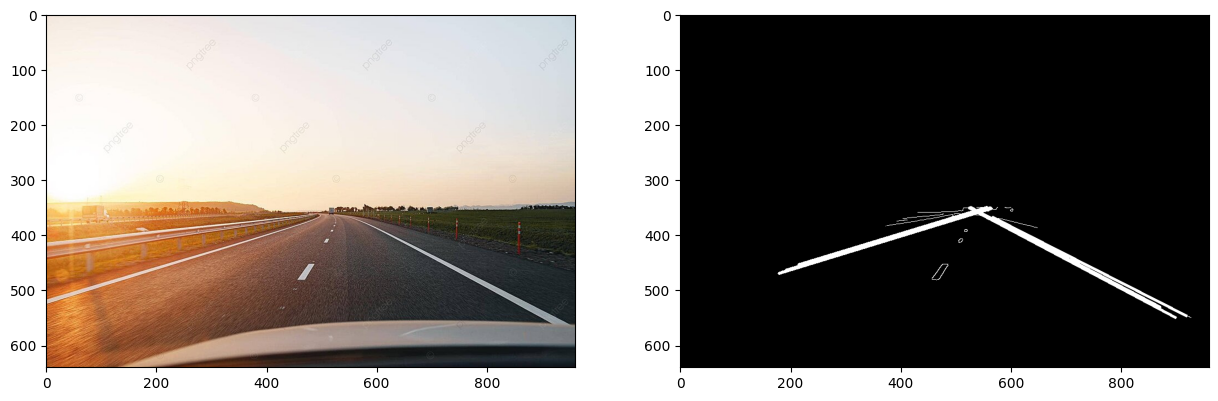

In [11]:
input = cv2.imread('road1.jpg')
model = lane_dectection(input)
output = model.run()
plt.figure(figsize=(15,15))
plt.subplot(121)
plt.imshow(cv2.cvtColor(input, cv2.COLOR_BGR2RGB))
plt.subplot(122)
plt.imshow(output, cmap='gray')
plt.show()

Test và giải thích các function

In [12]:
def get_slope(x1, y1, x2, y2):
    """
        giải thích hàm get_slope:
        input: 4 tọa độ của 1 đường thẳng
        output: góc nghiêng của đường thẳng đó so với trục x
        giải thích tại sao lại là (y2-y1)/(x2-x1):
        xét 1 đường thẳng có 2 điểm (x1,y1) và (x2,y2), góc nghiêng của đường thẳng đó so với trục x là góc mà đường thẳng đó tạo với trục x
        góc này được tính bằng cách lấy hiệu của 2 điểm theo trục y chia cho hiệu của 2 điểm theo trục x
        vì vậy ta có công thức (y2-y1)/(x2-x1)
        
    """
    return (y2-y1)/(x2-x1)

def grayscale(img):
    """
        grayscale sẽ giúp chuyển ảnh màu sang ảnh xám, lí do chuyển sang ảnh xám là vì ảnh xám sẽ giúp giảm chi phí tính toán
        ví dụ: ảnh màu sẽ có 3 kênh màu, mỗi kênh màu sẽ có 256 giá trị, tức là 1 pixel sẽ có 256^3 giá trị
        còn ảnh xám chỉ có 1 kênh màu, mỗi pixel sẽ có 256 giá trị, tức là 1 pixel sẽ có 256 giá trị
    """
    return cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

def canny(img, low_threshold, high_threshold):
    """
        Thuật toán canny sẽ giúp tìm ra các cạnh trong ảnh
    """
    return cv2.Canny(img, low_threshold, high_threshold)

def gaussian_blur(img, kernel_size):
    """
    gaussian_blur sẽ giúp giảm nhiễu cho ảnh
    """
    img = cv2.GaussianBlur(img, (kernel_size, kernel_size), 0)
    img = cv2.GaussianBlur(img, (kernel_size, kernel_size), 0)
    return cv2.GaussianBlur(img, (kernel_size, kernel_size), 0)

def region_of_interest(img, vertices):
    """
    ROI sẽ giúp chọn ra vùng quan trọng của ảnh, ở đây ta sẽ chọn ra vùng đường đi
    """
    mask = np.zeros_like(img)
    cv2.fillPoly(mask, vertices, 255)
    masked_image = cv2.bitwise_and(img, mask)
    return masked_image

def draw_lines(img, lines, color=[255, 0, 0], thickness=3):
    """
    draw_lines sẽ giúp vẽ các đường thẳng lên ảnh
    """
    for line in lines:
        for x1,y1,x2,y2 in line:
            cv2.line(img, (x1, y1), (x2, y2), color, thickness)

def split_lines(lines):
    """
    split_lines sẽ giúp phân chia các đường thẳng thành 2 nhóm, 1 nhóm là các đường thẳng bên trái, 1 nhóm là các đường thẳng bên phải
    """
    average_slope = np.mean([get_slope(x1, y1, x2, y2) for line in lines for x1,y1,x2,y2 in line])
    left = []
    right = []
    for line in lines:
        for x1,y1,x2,y2 in line:
            slope = get_slope(x1, y1, x2, y2)
            if slope < average_slope:
                left.append([x1, y1, x2, y2])
            else:
                right.append([x1, y1, x2, y2])
    left = np.array(left)
    right = np.array(right)
    mean_left = np.mean(left, axis=0)
    mean_right = np.mean(right, axis=0)
    return mean_left, mean_right

def hough_lines(img, rho, theta, threshold, min_line_len, max_line_gap):
    """
    hough_lines sẽ giúp tìm ra các đường thẳng trong ảnh, ở đây ta chỉ lấy các đường thẳng có độ dài lớn hơn 260
    
    return: ảnh với các đường thẳng đã được vẽ lên và tọa độ của các đường thẳng
    """
    lines = cv2.HoughLinesP(img, rho, theta, threshold, np.array([]), minLineLength=min_line_len, maxLineGap=max_line_gap)
    line_img = np.zeros((img.shape[0], img.shape[1], 3), dtype=np.uint8)
    lines = [line for line in lines if np.sqrt((line[0][0]-line[0][2])**2 + (line[0][1]-line[0][3])**2) > 260]
    return line_img, lines

In [13]:
# khởi tạo đỉnh của ROI
vertices = np.array([[[0,550],[450,350],[600,350],[960,550]]])

In [14]:
img = cv2.imread('road1.jpg')
intput = grayscale(img)
intput = gaussian_blur(intput, 5)
intput = canny(intput, 50, 150)
intput = region_of_interest(intput, vertices)
line_img, lines = hough_lines(intput, 1, np.pi/180, 50, 100, 160)
left, right = split_lines(lines)
left = left.reshape(1,4).astype(int)
right = right.reshape(1,4).astype(int)
lines = np.array([left, right])
draw_lines(intput, lines)

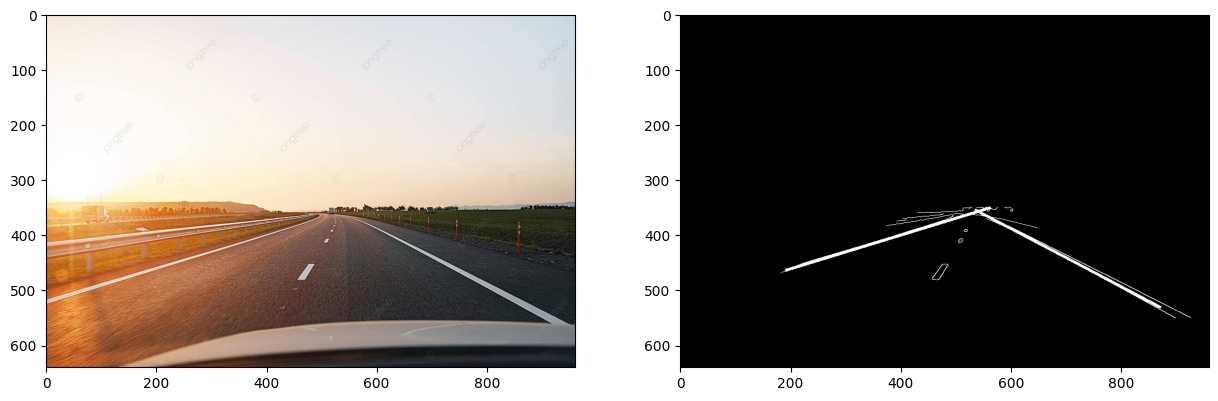

In [15]:
plt.figure(figsize=(15,15))
plt.subplot(121)
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.subplot(122)
plt.imshow(intput, cmap='gray')
plt.show()